In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
from IPython.display import Image, display
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.metrics import Recall, Precision
from keras.utils import plot_model
import tensorflow as tf

2025-11-18 06:17:46.755450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 06:17:46.759259: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 06:17:46.768594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-18 06:17:46.783306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-18 06:17:46.787437: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-18 06:17:46.799737: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    ensemble_visible = [model.input for model in members]
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    #plot_model(model, show_shapes=True, to_file='model_graph.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall(), Precision()])
    return model

In [3]:
def fit_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    #model.fit(X, inputy, epochs=10, batch_size=1000, verbose=1)
    model.fit(X, inputy, epochs=3, batch_size=256, verbose=1)

In [4]:
def predict_stacked_model(model, inputX):
    X = [inputX for _ in range(len(model.input))]
    return model.evaluate(X, verbose=1)

In [5]:
def evaluate_stacked_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))]
    return model.evaluate(X, inputy, verbose=1)

In [6]:
def make_functional(model):
    # Create new Input
    inp = tf.keras.Input(shape=(39,))
    out = model(inp)               # call loaded model <-- REBUILDS symbolic graph
    func_model = tf.keras.Model(inp, out)
    return func_model

In [7]:
filename_model_N1 = '../Train/model_N1.keras'
loaded_model_N1 = load_model(filename_model_N1)

In [8]:
filename_model_N2 = '../Train/model_N2.keras'
loaded_model_N2 = load_model(filename_model_N2)

In [9]:
filename_model_N3 = '../Train/model_N3.keras'
loaded_model_N3 = load_model(filename_model_N3)

In [10]:
filename_model_N4 = '../Train/model_N4.keras'
loaded_model_N4 = load_model(filename_model_N4)

In [11]:
filename_model_N5 = '../Train/model_N5.keras'
loaded_model_N5 = load_model(filename_model_N5)

In [12]:
all_models = [
    make_functional(loaded_model_N1),
    make_functional(loaded_model_N2),
    make_functional(loaded_model_N3),
    make_functional(loaded_model_N4),
    make_functional(loaded_model_N5),
]

In [13]:
stacked_model_for_N1 = define_stacked_model(all_models)

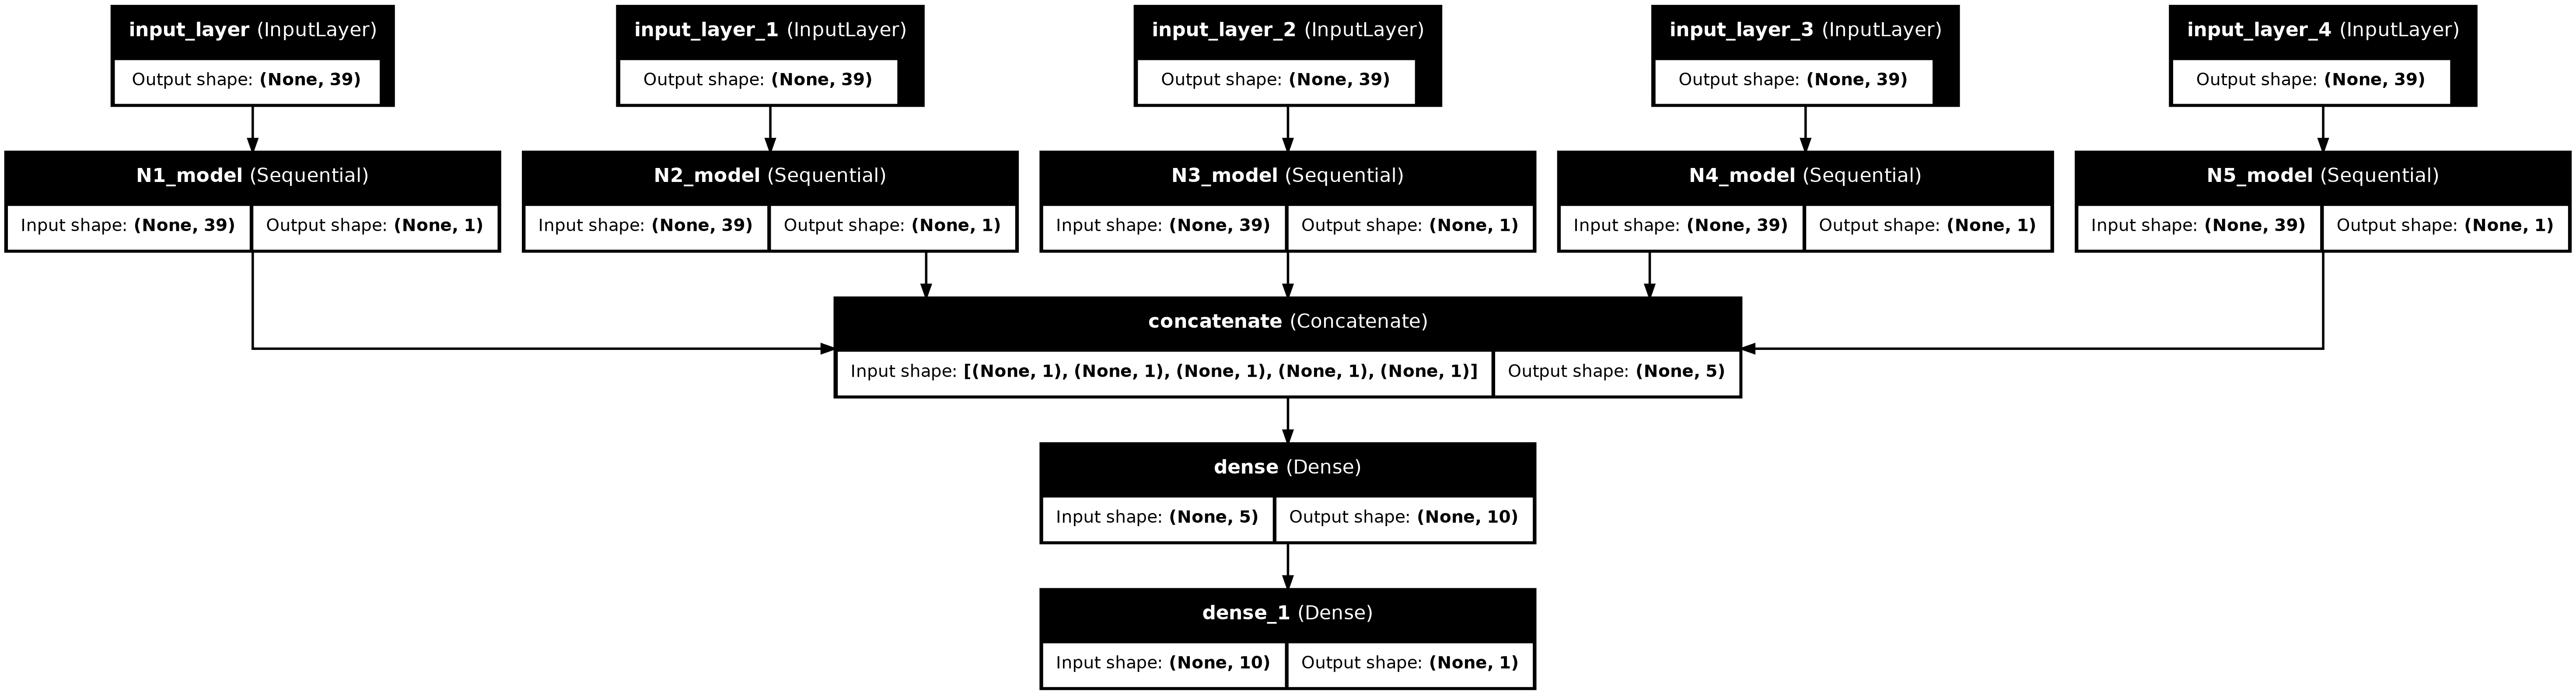

In [14]:
plot_model(
    stacked_model_for_N1,
    to_file="stacked_model_sec1_N1.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec1_N1.png"))

In [15]:
df1_test = pd.read_parquet("../Dataset/NF-UNSW-NB15/NF-UNSW-NB15-V2_test.parquet")

In [16]:
df1_sample = pd.read_parquet("../Dataset/NF-UNSW-NB15/NF-UNSW-NB15-V2_sample.parquet")

In [17]:
df1_valid = pd.read_parquet("../Dataset/NF-UNSW-NB15/NF-UNSW-NB15-V2_valid.parquet")

In [18]:
load_X_df1_sample = df1_sample.drop(["Label"],axis=1)
Y_df1_sample = df1_sample["Label"]

In [19]:
load_X_df1_test = df1_test.drop(["Label"],axis=1)
Y_df1_test = df1_test["Label"]

In [20]:
load_X_df1_valid = df1_valid.drop(["Label"],axis=1)
Y_df1_valid = df1_valid["Label"]

In [21]:
scaler_df1 = QuantileTransformer(output_distribution='normal')

In [22]:
X_df1_sample = scaler_df1.fit_transform(load_X_df1_sample)

In [23]:
X_df1_test = scaler_df1.fit_transform(load_X_df1_test)

In [24]:
X_df1_valid = scaler_df1.fit_transform(load_X_df1_valid)

In [25]:
fit_stacked_model(stacked_model_for_N1, X_df1_sample, Y_df1_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_77', 'keras_tensor_79', 'keras_tensor_81', 'keras_tensor_83']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8160 - loss: 0.4538 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9643 - loss: 0.0710 - precision: 0.4707 - recall: 0.0715
Epoch 3/3
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9918 - loss: 0.0348 - precision: 0.9166 - recall: 0.8614


In [26]:
score_stack_for_N1 = evaluate_stacked_model(stacked_model_for_N1, X_df1_test, Y_df1_test)

print('Test loss:', score_stack_for_N1[0]) 
print('Test accuracy:', score_stack_for_N1[1])
print('Test recfor:', score_stack_for_N1[2]) 
print('Test precision:', score_stack_for_N1[3])

16764/16764 ━━━━━━━━━━━━━━━━━━━━ 17s 977us/step - accuracy: 0.9933 - loss: 0.0283 - precision: 0.9284 - recall: 0.8897
Test loss: 0.028006551787257195
Test accuracy: 0.9933373332023621
Test recfor: 0.8925423622131348
Test precision: 0.9277331829071045


In [27]:
stacked_model_for_N2 = define_stacked_model(all_models)

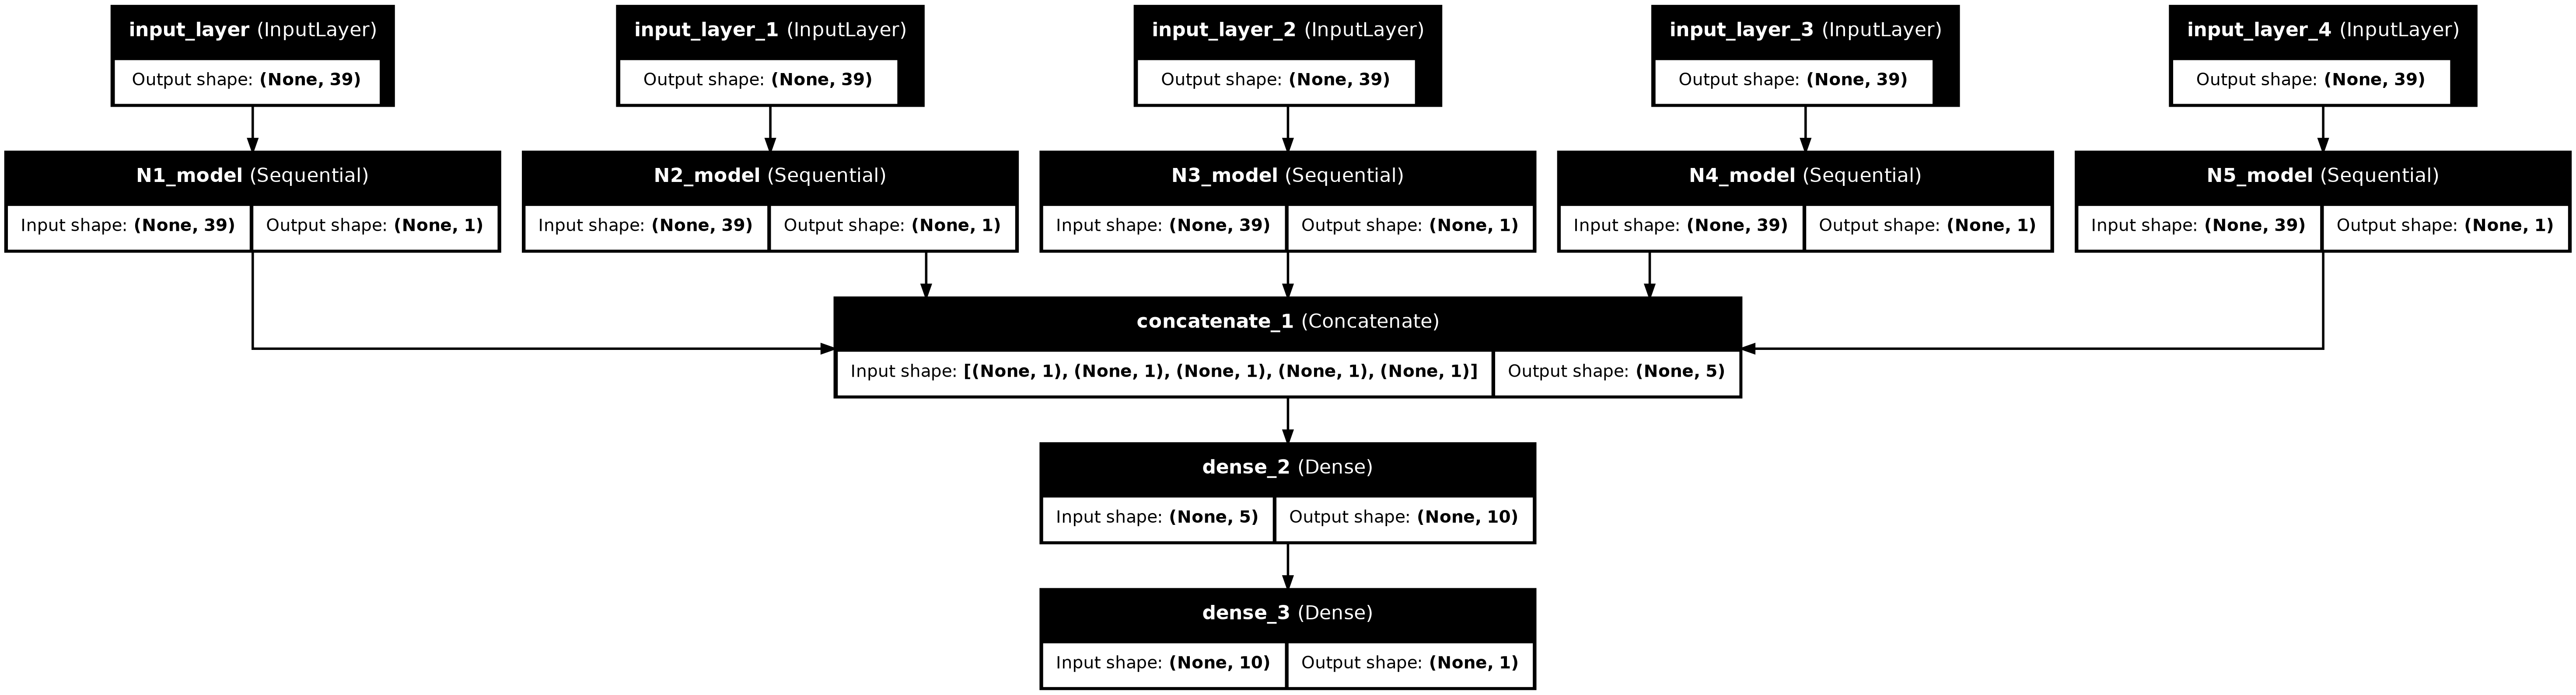

In [28]:
plot_model(
    stacked_model_for_N2,
    to_file="stacked_model_sec1_N2.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec1_N2.png"))

In [29]:
df2_test = pd.read_parquet("../Dataset/NF-ToN-IoT/NF-ToN-IoT-V2_test.parquet")

In [30]:
df2_sample = pd.read_parquet("../Dataset/NF-ToN-IoT/NF-ToN-IoT-V2_sample.parquet")

In [31]:
df2_valid = pd.read_parquet("../Dataset/NF-ToN-IoT/NF-ToN-IoT-V2_valid.parquet")

In [32]:
load_X_df2_sample = df2_sample.drop(["Label"],axis=1)
Y_df2_sample = df2_sample["Label"]

In [33]:
load_X_df2_test = df2_test.drop(["Label"],axis=1)
Y_df2_test = df2_test["Label"]

In [34]:
load_X_df2_valid = df2_valid.drop(["Label"],axis=1)
Y_df2_valid = df2_valid["Label"]

In [35]:
scaler_df2 = QuantileTransformer(output_distribution='normal')

In [36]:
X_df2_sample = scaler_df2.fit_transform(load_X_df2_sample)

In [37]:
X_df2_test = scaler_df2.fit_transform(load_X_df2_test)

In [38]:
X_df2_valid = scaler_df2.fit_transform(load_X_df2_valid)

In [39]:
fit_stacked_model(stacked_model_for_N2, X_df2_sample, Y_df2_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_77', 'keras_tensor_79', 'keras_tensor_81', 'keras_tensor_83']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8615 - loss: 0.2828 - precision_1: 0.9131 - recall_1: 0.8635
Epoch 2/3
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9742 - loss: 0.0822 - precision_1: 0.9782 - recall_1: 0.9865
Epoch 3/3
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9746 - loss: 0.0797 - precision_1: 0.9784 - recall_1: 0.9868


In [40]:
score_stack_for_N2 = evaluate_stacked_model(stacked_model_for_N2, X_df2_test, Y_df2_test)

print('Test loss:', score_stack_for_N2[0]) 
print('Test accuracy:', score_stack_for_N2[1])
print('Test recfor:', score_stack_for_N2[2]) 
print('Test precision:', score_stack_for_N2[3])

110834/110834 ━━━━━━━━━━━━━━━━━━━━ 106s 956us/step - accuracy: 0.9748 - loss: 0.0815 - precision_1: 0.9788 - recall_1: 0.9866
Test loss: 0.08178669214248657
Test accuracy: 0.9747347235679626
Test recfor: 0.9865924119949341
Test precision: 0.9787734150886536


In [41]:
stacked_model_for_N3 = define_stacked_model(all_models)

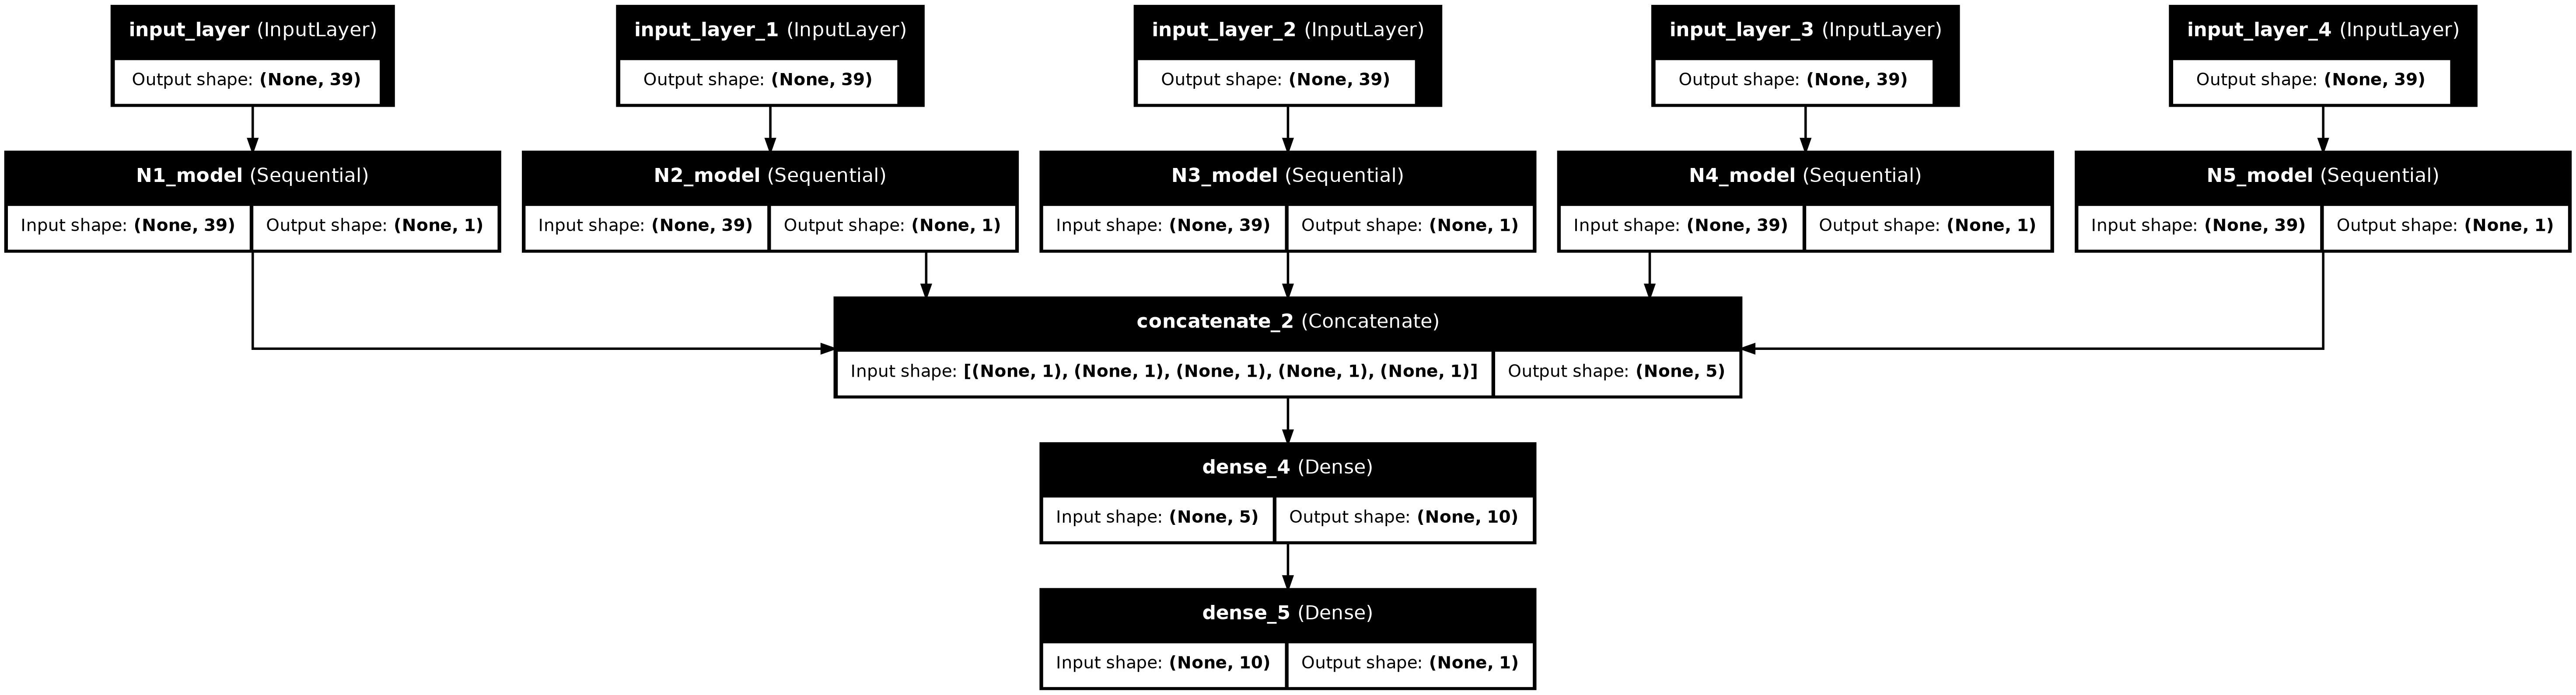

In [42]:
plot_model(
    stacked_model_for_N3,
    to_file="stacked_model_sec1_N3.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec1_N3.png"))

In [43]:
df3_test = pd.read_parquet("../Dataset/NF-BoT-IoT/NF-BoT-IoT-V2_test.parquet")

In [44]:
df3_sample = pd.read_parquet("../Dataset/NF-BoT-IoT/NF-BoT-IoT-V2_sample.parquet")

In [45]:
df3_valid = pd.read_parquet("../Dataset/NF-BoT-IoT/NF-BoT-IoT-V2_valid.parquet")

In [46]:
load_X_df3_sample = df3_sample.drop(["Label"],axis=1)
Y_df3_sample = df3_sample["Label"]

In [47]:
load_X_df3_test = df3_test.drop(["Label"],axis=1)
Y_df3_test = df3_test["Label"]

In [48]:
load_X_df3_valid = df3_valid.drop(["Label"],axis=1)
Y_df3_valid = df3_valid["Label"]

In [49]:
scaler_df3 = QuantileTransformer(output_distribution='normal')

In [50]:
X_df3_sample = scaler_df3.fit_transform(load_X_df3_sample)

In [51]:
X_df3_test = scaler_df3.fit_transform(load_X_df3_test)

In [52]:
X_df3_valid = scaler_df3.fit_transform(load_X_df3_valid)

In [53]:
fit_stacked_model(stacked_model_for_N3, X_df3_sample, Y_df3_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_77', 'keras_tensor_79', 'keras_tensor_81', 'keras_tensor_83']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


8318/8318 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9536 - loss: 0.1073 - precision_2: 0.9927 - recall_2: 0.9572
Epoch 2/3
8318/8318 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9975 - loss: 0.0091 - precision_2: 0.9979 - recall_2: 0.9995
Epoch 3/3
8318/8318 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9982 - loss: 0.0077 - precision_2: 0.9985 - recall_2: 0.9997


In [54]:
score_stack_for_N3 = evaluate_stacked_model(stacked_model_for_N3, X_df3_test, Y_df3_test)

print('Test loss:', score_stack_for_N3[0]) 
print('Test accuracy:', score_stack_for_N3[1])
print('Test recfor:', score_stack_for_N3[2]) 
print('Test precision:', score_stack_for_N3[3])

256670/256670 ━━━━━━━━━━━━━━━━━━━━ 252s 981us/step - accuracy: 0.9983 - loss: 0.0074 - precision_2: 0.9987 - recall_2: 0.9996
Test loss: 0.007455954793840647
Test accuracy: 0.9982455372810364
Test recfor: 0.9995663166046143
Test precision: 0.9986729621887207


In [55]:
stacked_model_for_N4 = define_stacked_model(all_models)

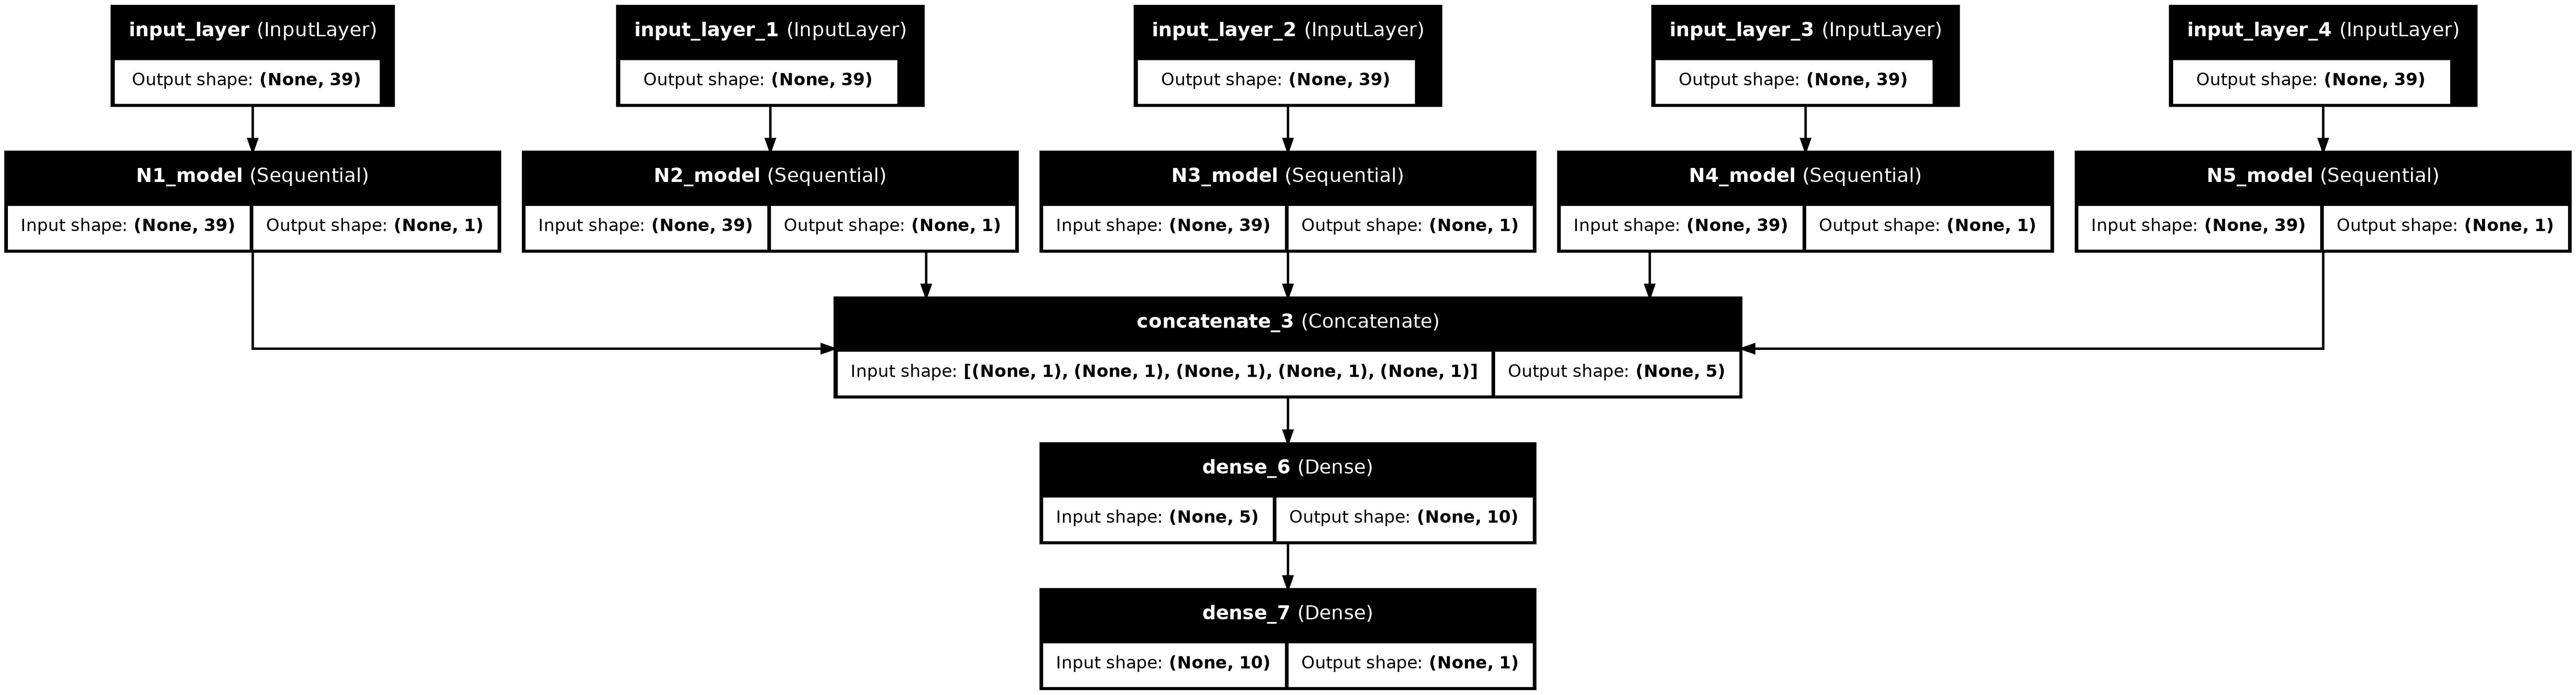

In [56]:
plot_model(
    stacked_model_for_N4,
    to_file="stacked_model_sec1_N4.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec1_N4.png"))

In [57]:
df4_test = pd.read_parquet("../Dataset/NF-CSE-CIC-IDS2018/NF-CSE-CIC-IDS2018-V2_test.parquet")

In [58]:
df4_sample = pd.read_parquet("../Dataset/NF-CSE-CIC-IDS2018/NF-CSE-CIC-IDS2018-V2_sample.parquet")

In [59]:
df4_valid = pd.read_parquet("../Dataset/NF-CSE-CIC-IDS2018/NF-CSE-CIC-IDS2018-V2_valid.parquet")

In [60]:
load_X_df4_sample = df4_sample.drop(["Label"],axis=1)
Y_df4_sample = df4_sample["Label"]

In [61]:
load_X_df4_test = df4_test.drop(["Label"],axis=1)
Y_df4_test = df4_test["Label"]

In [62]:
load_X_df4_valid = df4_valid.drop(["Label"],axis=1)
Y_df4_valid = df4_valid["Label"]

In [63]:
scaler_df4 = QuantileTransformer(output_distribution='normal')

In [64]:
X_df4_sample = scaler_df4.fit_transform(load_X_df4_sample)

In [65]:
X_df4_test = scaler_df4.fit_transform(load_X_df4_test)

In [66]:
X_df4_valid = scaler_df4.fit_transform(load_X_df4_valid)

In [67]:
fit_stacked_model(stacked_model_for_N4, X_df4_sample, Y_df4_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_77', 'keras_tensor_79', 'keras_tensor_81', 'keras_tensor_83']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


4684/4684 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9752 - loss: 0.1423 - precision_3: 0.8973 - recall_3: 0.9354
Epoch 2/3
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9942 - loss: 0.0335 - precision_3: 0.9971 - recall_3: 0.9540
Epoch 3/3
4684/4684 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9942 - loss: 0.0334 - precision_3: 0.9971 - recall_3: 0.9540


In [68]:
score_stack_for_N4 = evaluate_stacked_model(stacked_model_for_N4, X_df4_test, Y_df4_test)

print('Test loss:', score_stack_for_N4[0]) 
print('Test accuracy:', score_stack_for_N4[1])
print('Test recfor:', score_stack_for_N4[2]) 
print('Test precision:', score_stack_for_N4[3])

144532/144532 ━━━━━━━━━━━━━━━━━━━━ 143s 989us/step - accuracy: 0.9940 - loss: 0.0340 - precision_3: 0.9963 - recall_3: 0.9532
Test loss: 0.03364139050245285
Test accuracy: 0.9941046833992004
Test recfor: 0.9537608623504639
Test precision: 0.996289849281311


In [69]:
stacked_model_for_N5 = define_stacked_model(all_models)

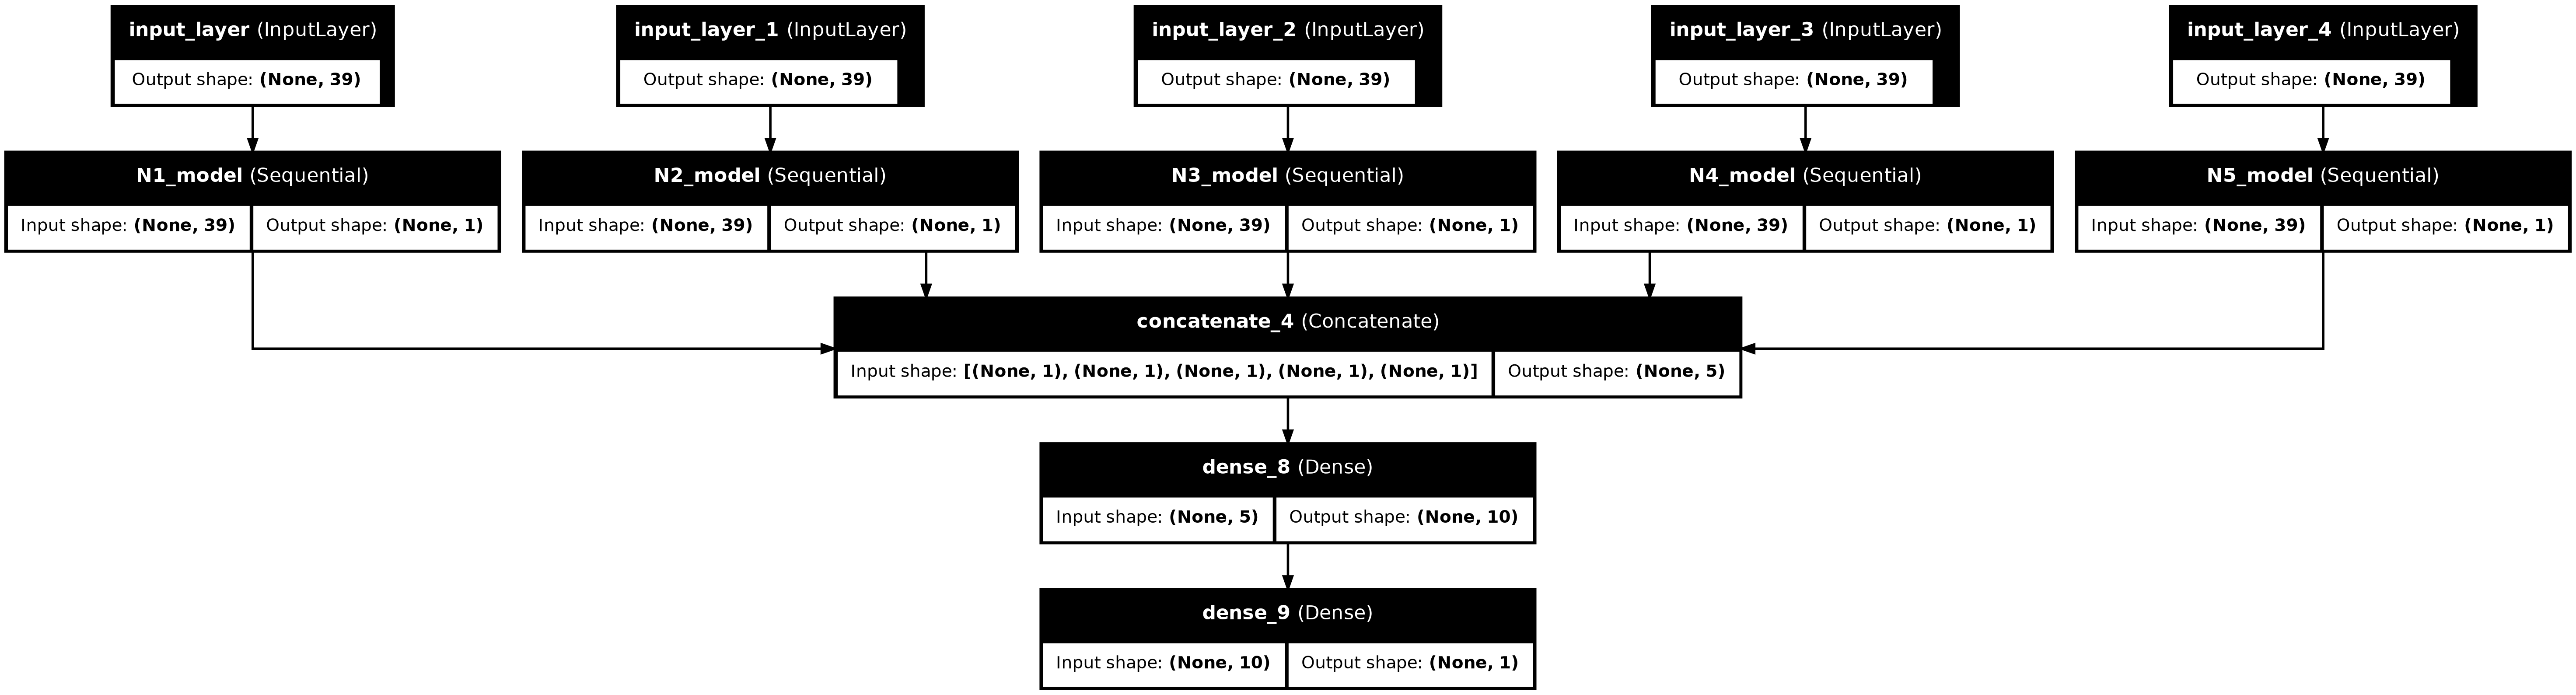

In [70]:
plot_model(
    stacked_model_for_N5,
    to_file="stacked_model_sec1_N5.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)

display(Image(filename="stacked_model_sec1_N5.png"))

In [71]:
df5_test = pd.read_parquet("../Dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2_test.parquet")

In [72]:
df5_sample = pd.read_parquet("../Dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2_sample.parquet")

In [73]:
df5_valid = pd.read_parquet("../Dataset/NF-UQ-NIDS/NF-UQ-NIDS-V2_valid.parquet")

In [74]:
load_X_df5_sample = df5_sample.drop(["Label"],axis=1)
Y_df5_sample = df5_sample["Label"]

In [75]:
load_X_df5_test = df5_test.drop(["Label"],axis=1)
Y_df5_test = df5_test["Label"]

In [76]:
load_X_df5_valid = df5_valid.drop(["Label"],axis=1)
Y_df5_valid = df5_valid["Label"]

In [77]:
scaler_df5 = QuantileTransformer(output_distribution='normal')

In [78]:
X_df5_sample = scaler_df5.fit_transform(load_X_df5_sample)

In [79]:
X_df5_test = scaler_df5.fit_transform(load_X_df5_test)

In [80]:
X_df5_valid = scaler_df5.fit_transform(load_X_df5_valid)

In [81]:
fit_stacked_model(stacked_model_for_N5, X_df5_sample, Y_df5_sample)

Epoch 1/3


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_77', 'keras_tensor_79', 'keras_tensor_81', 'keras_tensor_83']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


17137/17137 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9585 - loss: 0.1264 - precision_4: 0.9620 - recall_4: 0.9766
Epoch 2/3
17137/17137 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9719 - loss: 0.0819 - precision_4: 0.9738 - recall_4: 0.9845
Epoch 3/3
17137/17137 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9718 - loss: 0.0819 - precision_4: 0.9736 - recall_4: 0.9846


In [82]:
score_stack_for_N5 = evaluate_stacked_model(stacked_model_for_N5, X_df5_test, Y_df5_test)

print('Test loss:', score_stack_for_N5[0]) 
print('Test accuracy:', score_stack_for_N5[1])
print('Test recfor:', score_stack_for_N5[2]) 
print('Test precision:', score_stack_for_N5[3])

528796/528796 ━━━━━━━━━━━━━━━━━━━━ 516s 970us/step - accuracy: 0.9758 - loss: 0.0708 - precision_4: 0.9745 - recall_4: 0.9897
Test loss: 0.07087082415819168
Test accuracy: 0.9757493734359741
Test recfor: 0.9897080063819885
Test precision: 0.9744504690170288
